In [1]:
import pandas as pd
import sqlite3

con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
player_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [2]:
player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [3]:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

def prepare_dataframe(df):
    df = df[df.defensive_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['defensive_work_rate'], prefix='defensive_work_rate')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['preferred_foot'], prefix='preferred_foot')],axis=1)
    df = df[df.attacking_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['attacking_work_rate'], prefix='attacking_work_rate')],axis=1)
    df = df.drop(df_one_hot_list, axis=1)
    return df

player_df = prepare_dataframe(player_df)

In [4]:
# Ok IDEE: Neue Daten generieren OHNE die Verwendung von GANs. Dazu erstelle ich Buckets (n-Viele) und gebe die percentiles wieder. 

def get_col_quantile(df, col, buckets):
    step = 1 / buckets
    container = []
    
    for i in range(buckets):
        container.append(df[col].quantile(step * i))
    
    return container

quantile = get_col_quantile(player_df, 'overall_rating', 10)
quantile

[47.0, 61.0, 63.0, 65.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0]

In [5]:
print([player_df['overall_rating'].mean(), player_df['overall_rating'].max(), player_df['overall_rating'].min(), player_df['overall_rating'].std()])

[68.27505803976986, 94.0, 47.0, 6.282576855113117]


In [6]:
def split_df_in_buckets(df, col, buckets):
    split = df.shape[0] / buckets
    container = []
    
    for i in range(buckets):
        container.append(df.sort_values(by=[col])[int(i*split):int((i+1)*split)])
        
    return container

In [7]:
buckets = split_df_in_buckets(player_df, 'overall_rating', 10)
buckets[1]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
3023,3027,177843,Enes Sipovic,226628,1990-09-11 00:00:00,198.12,203,177843,2015-05-15 00:00:00,50485,...,11.0,9.0,0,0,1,0,1,0,0,1
9228,9238,301241,Ross Barbour,212907,1993-02-01 00:00:00,177.80,157,301241,2016-03-10 00:00:00,153755,...,16.0,11.0,0,0,1,0,1,0,0,1
1299,1302,89548,Bojan Bozovic,164407,1985-02-03 00:00:00,190.50,185,89548,2015-07-03 00:00:00,22037,...,14.0,13.0,0,0,1,0,1,1,0,0
7391,7401,192679,Michael Tidser,213460,1990-01-15 00:00:00,182.88,168,192679,2015-01-09 00:00:00,123822,...,8.0,13.0,0,0,1,1,0,1,0,0
6849,6858,32658,Mark Brown,45162,1981-02-28 00:00:00,185.42,172,32658,2014-12-05 00:00:00,114391,...,60.0,60.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,10978,26674,Youssef El Akchaoui,109809,1981-02-18 00:00:00,175.26,159,26674,2012-08-31 00:00:00,182524,...,10.0,12.0,0,0,1,1,0,0,0,1
9600,9611,68827,Sebastian Ziajka,204145,1982-12-15 00:00:00,182.88,165,68827,2016-05-05 00:00:00,159873,...,15.0,9.0,0,1,0,1,0,1,0,0
992,995,173983,Arthur,192038,1987-01-14 00:00:00,177.80,150,173983,2016-03-24 00:00:00,17121,...,6.0,13.0,0,0,1,1,0,1,0,0
9598,9609,299021,Sebastian Steblecki,208907,1992-01-16 00:00:00,185.42,154,299021,2016-03-03 00:00:00,159845,...,7.0,16.0,0,0,1,0,1,1,0,0


In [8]:
for df in buckets:
    print(df['overall_rating'].mean())
    print(df['overall_rating'].std())

57.41818181818182
2.6908211441868066
61.98789101917255
0.7887175962897163
64.0100908173562
0.6371488669161706
65.58484848484848
0.4929971966119816
67.27547931382442
0.508308888956166
68.85671039354187
0.6127046150767197
70.62525252525252
0.591453016089472
72.63471241170535
0.6290652782344168
74.91422805247225
0.795002944191316
79.43188698284561
2.633343377683589


In [9]:
player_df.dtypes

id                              int64
player_api_id                   int64
player_name                    object
player_fifa_api_id              int64
birthday                       object
height                        float64
weight                          int64
player_api_id                   int64
date                           object
id                              int64
player_fifa_api_id              int64
player_api_id                   int64
date                           object
overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed

In [10]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd
#referring to https://stats.stackexchange.com/questions/215938/generate-synthetic-data-to-match-sample-data

df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
column_names = list(df.columns)

def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
       #create synthetic samples only for a subset of T.
       #TODO: select random minortiy samples
       N = 100
       pass

    if (N % 100) != 0:
       raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(int(N)):
            nn_index = choice(nn[0]) #Take one of the nearest neighbour
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i] # calculates the difference between current and neighbour
            gap = np.random.random() # bring some randomness to the mix
            S[int(n + i * N), :] = T[i,:] + gap * dif[:] # set the new data
    return S

df = df.to_numpy()
new_data = SMOTE(df,50,10) # this is where I call the function and expect new_data to be generated with larger number of samples than original df.
new_data.shape

(9907, 43)

In [11]:
new_df = pd.DataFrame(new_data, columns=column_names)

In [12]:
def laplaceMechanism(x, epsilon):
    x += np.random.laplace(0, 1.0/epsilon, 1)[0]
    return x

for col in column_names:
    new_df[col] = new_df[col].apply(laplaceMechanism, args=(2,))

In [13]:
def compare_two_dataframe(df1, df2, col_names, buckets = 10):
    res = []
    dif_total = 0
    
    for col in col_names:
        q1 = get_col_quantile(df1, col, buckets)
        q2 = get_col_quantile(df2, col, buckets)
        
        dif = []
        for i in range(buckets):
            dif.append(q1[i] - q2[i])
            
        percent = 1
        if sum(q1) > sum(q2):
            percent = sum(q2) / sum(q1)
        elif sum(q1) < sum(q2):
            percent = sum(q1) / sum(q2)
            
        dif_total += sum(dif)
        entry = {
            'name': col,
            'q1': q1,
            'q2': q2,
            'dif': dif,
            'dif_total': sum(dif),
            'percent': percent,
        }
        #res.append(entry)
        res.append(percent)
        
    return (res, dif_total)

In [14]:
res, dif_total = compare_two_dataframe(new_df, player_df, column_names, 100)
dif_total

135.23450552417705

In [15]:
import matplotlib.pyplot as plt

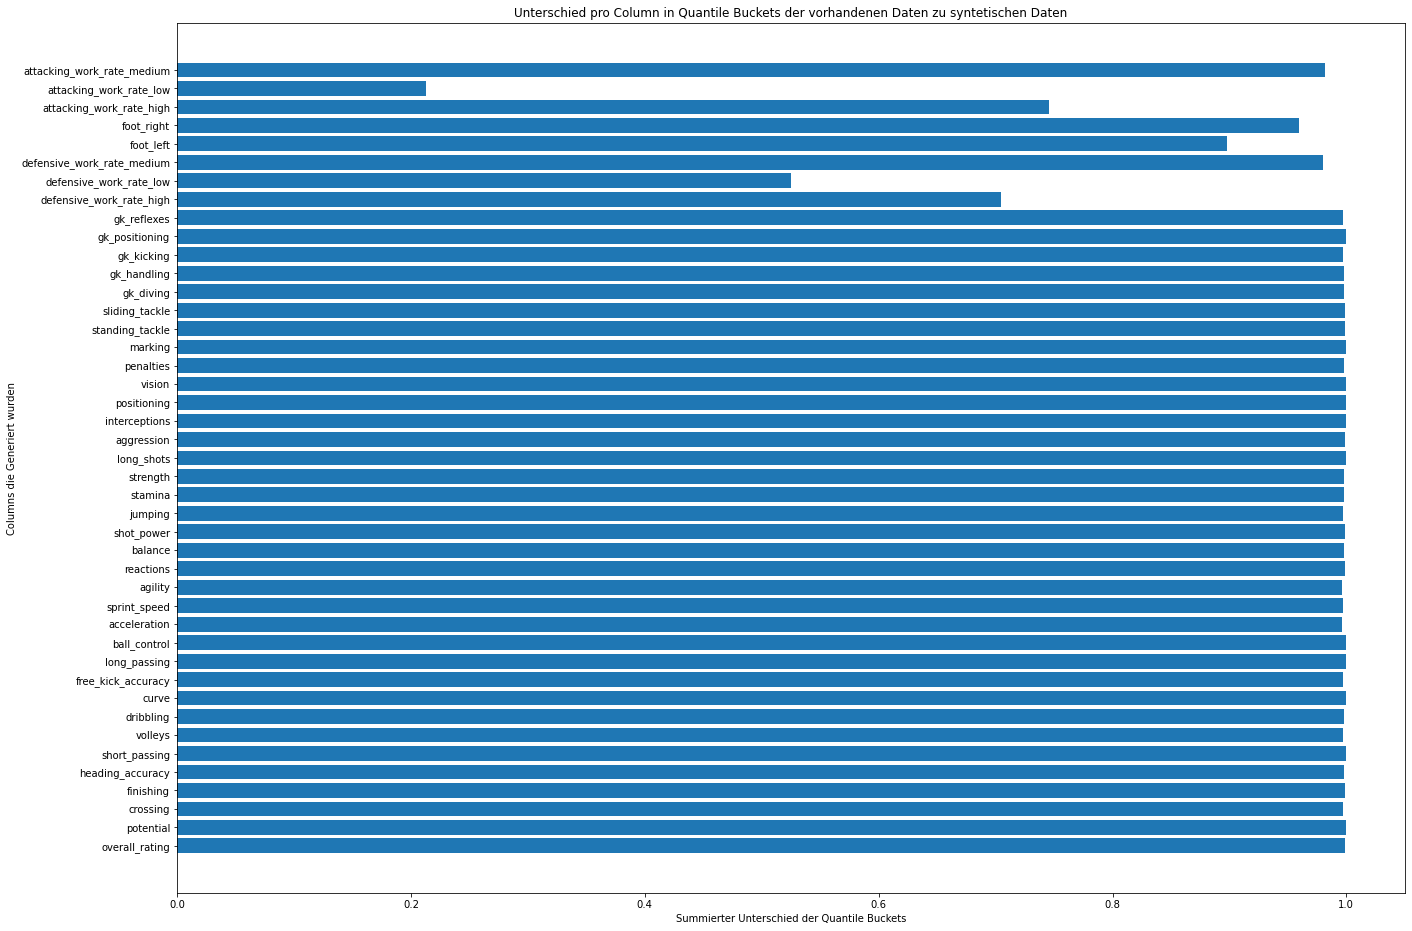

In [16]:
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [17]:
print(f'Overall accuracy: {sum(res) / len(res)}')

Overall accuracy: 0.9524603488277968


In [18]:
new_df[new_df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1789,91.257046,91.825074,80.807235,95.327281,85.781133,81.189633,86.886187,91.914321,88.140089,77.491176,...,14.276941,10.050913,0.007118,1.838167,-0.011181,-0.671262,1.533222,0.938187,-0.560683,0.198302
5534,92.131511,93.038436,79.427235,93.201288,71.577026,85.457040,84.717537,93.745086,88.618402,88.942505,...,11.692281,7.012793,0.335997,1.250152,1.154559,0.875784,0.688447,-0.236201,0.219366,0.219316
8651,92.183696,92.713309,78.709052,92.548632,70.653249,86.865972,83.380870,96.689954,88.564728,87.913863,...,13.505227,8.487518,-1.078046,1.202469,0.647478,0.458046,-0.283912,1.768838,-0.620104,1.231252


In [19]:
df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
df[df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
6170,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,...,14.0,8.0,0,1,0,1,0,0,0,1


In [20]:
# Ich versuche jetzt, ein Generator Modell zu erstellen welches mir neue Daten anhand eines Noise Vektors generiert. 
# Der Generator selbst hat die Original Daten nie gesehen, er nimmt einfach nur Random entgegen und basierend darauf erstellt er etwas. 
# Wie gut das Ergebnis ist, bestimmt später der Discriminator, den ich vermutlich erst später implementiere.

# Zu beginn ist das Ziel, ein super einfachen Generator zu erstellen, der mir basierend auf die eingehende Anzahl an spalten "random" Ausgaben erzeugt. Logischerweise noch super random da 0 trainiert

In [21]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe. 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.90
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [33]:
def make_generator_model(df):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    # model.add(layers.BatchNormalization()) # BN macht man meist nur bei CNNs..
    model.add(layers.LeakyReLU())
    
    #model.add(layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # => None ist batch size, rest ist der Shape den wir haben wollen
    
    #model.add(layers.Flatten())
    model.add(layers.Dense(256, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [34]:
train_df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
generator = make_generator_model(train_df)

noise = tf.random.normal([1, 100])

generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[-0.05219722,  0.02733732, -0.00304472,  0.14661025, -0.02642279,
        -0.05358965, -0.00225665,  0.10866071,  0.07477113, -0.03005433,
         0.0893704 ,  0.10511974,  0.01968922, -0.00112873, -0.07617372,
         0.12298857, -0.08579806,  0.04026718,  0.01638558, -0.14354616,
        -0.0175647 , -0.12820183,  0.08189875, -0.06945734,  0.17133832,
        -0.00182441, -0.05184693,  0.09174573,  0.04585119, -0.05198814,
        -0.09515165, -0.04162956,  0.04646676,  0.18645057, -0.28859657,
        -0.05133644, -0.15405111, -0.12164722,  0.02218802, -0.05832376,
         0.01889307,  0.05585629,  0.08224634]], dtype=float32)>

In [35]:
def make_discriminator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model(train_df)
decision = discriminator(generated_data)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01985381]], dtype=float32)>

In [37]:
# Cookie Cutter aus dem DCGAN Notebook

In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

lerning_rate = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(lerning_rate)

checkpoint_dir = './checkpoints/dcgan_soccer_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch +1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    print(predictions.shape)

In [42]:
normalized_train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,0.425532,0.488889,0.500000,0.433333,0.727273,0.614458,0.448276,0.500000,0.443182,0.388889,...,0.078652,0.078652,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.574468,0.600000,0.860465,0.533333,0.579545,0.734940,0.402299,0.744444,0.727273,0.722222,...,0.089888,0.123596,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.382979,0.400000,0.674419,0.588889,0.602273,0.674699,0.540230,0.666667,0.693182,0.655556,...,0.089888,0.134831,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.468085,0.444444,0.593023,0.177778,0.693182,0.662651,0.494253,0.555556,0.363636,0.400000,...,0.123596,0.112360,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.489362,0.466667,0.465116,0.322222,0.750000,0.662651,0.321839,0.455556,0.409091,0.233333,...,0.123596,0.112360,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11057,0.361702,0.333333,0.686047,0.611111,0.397727,0.698795,0.333333,0.766667,0.534091,0.544444,...,0.078652,0.078652,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
11058,0.595745,0.600000,0.593023,0.388889,0.750000,0.674699,0.390805,0.555556,0.340909,0.377778,...,0.101124,0.078652,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
11059,0.553191,0.533333,0.418605,0.244444,0.761364,0.722892,0.287356,0.533333,0.488636,0.322222,...,0.078652,0.123596,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
11060,0.340426,0.400000,0.686047,0.433333,0.590909,0.638554,0.505747,0.566667,0.693182,0.666667,...,0.044944,0.078652,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [44]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_train_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [45]:
train(train_dataset, EPOCHS * 20)

(16, 43)
Time for epoch 1000 is 0.13685965538024902 sec


In [107]:
noise = tf.random.normal([9907, 100])

generated_data = generator(noise, training=False)

In [108]:
gan_df = pd.DataFrame(data=generated_data, columns=column_names).astype("float")

-179042.72417176238
Overall accuracy: 0.13385445019040795


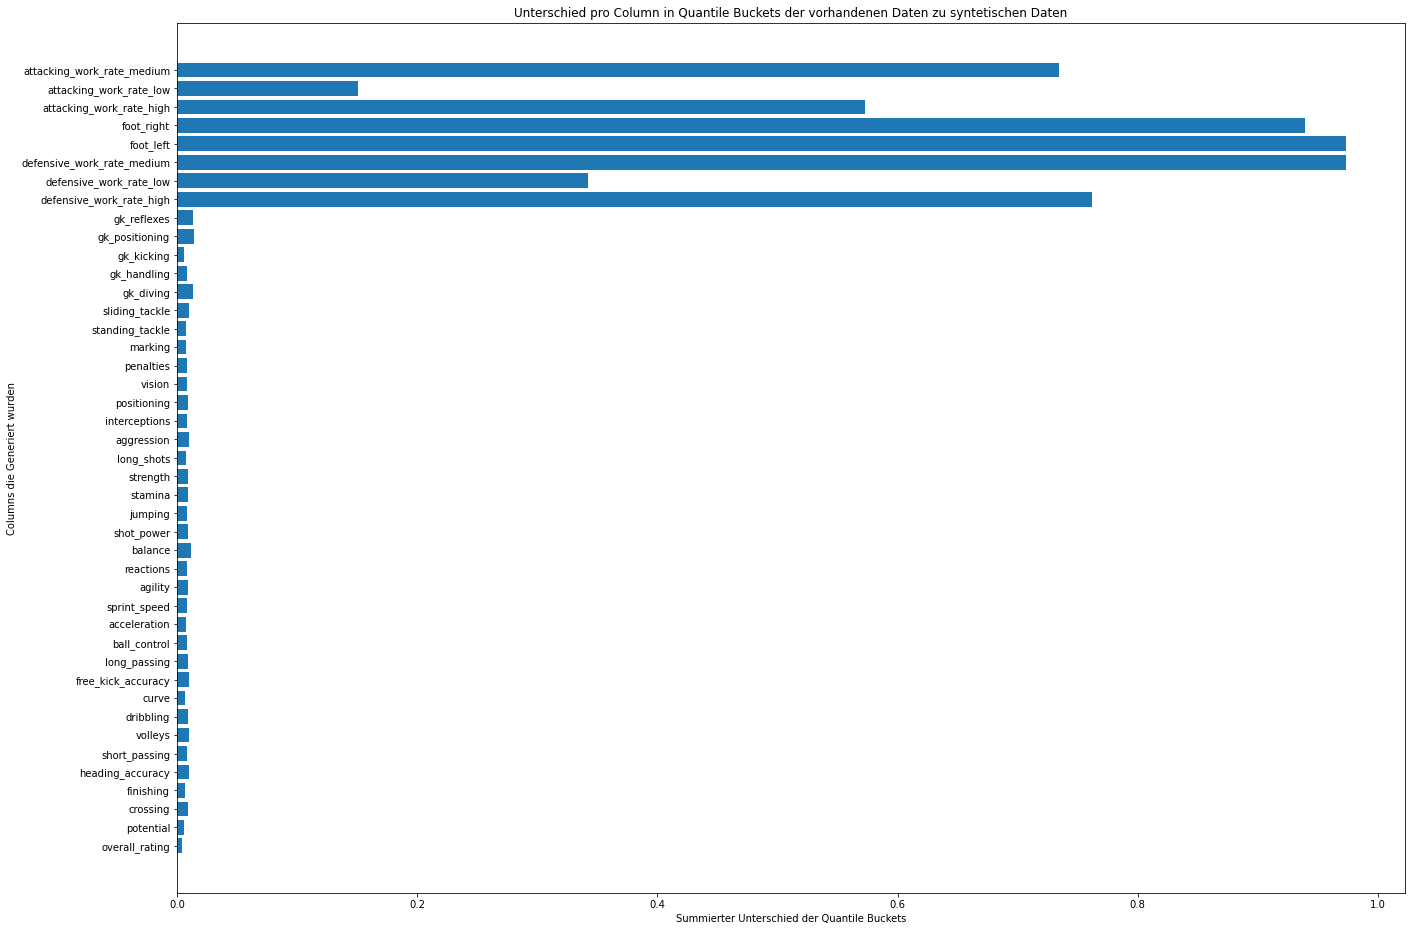

In [109]:
res, dif_total = compare_two_dataframe(gan_df, train_df, column_names, 100)
print(dif_total)
print(f'Overall accuracy: {sum(res) / len(res)}')
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [110]:
gan_df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,0.212030,0.374553,0.565481,0.457623,0.551775,0.602799,0.605128,0.607159,0.354790,0.514632,...,0.117858,0.116001,-0.052242,-0.002461,0.982256,0.050534,0.986087,-0.045804,0.016060,0.996439
1,0.494410,0.519848,0.411644,0.528395,0.629119,0.645878,0.452251,0.492029,0.581407,0.847603,...,0.134710,0.260101,0.134260,0.595906,0.474526,-0.033233,1.067208,0.062623,1.146394,-0.073155
2,0.410852,0.496856,0.453208,0.442506,0.667075,0.604618,0.436677,0.473258,0.386427,0.690189,...,0.150317,0.202869,0.027452,0.156233,0.996177,-0.012251,1.061052,0.286576,1.070539,-0.216470
3,0.226333,0.386361,0.459249,0.283127,0.549896,0.529652,0.507504,0.482548,0.298785,0.426143,...,0.145019,0.215743,0.640149,0.032424,0.244068,-0.032215,0.956499,-0.096009,0.211448,0.759024
4,0.406727,0.508476,0.325454,0.079861,0.731985,0.608068,0.199058,0.259991,0.132267,0.433868,...,0.172503,0.148056,-0.044249,-0.033228,1.106484,0.017304,0.874322,-0.292282,0.734428,0.558795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,0.304298,0.362930,0.345861,0.240776,0.538258,0.487603,0.273077,0.309753,0.277132,0.541176,...,0.129692,0.153147,0.051890,0.112571,0.847747,-0.017520,0.809178,0.087255,0.994769,-0.163800
9903,0.522176,0.629810,1.112626,0.357066,0.791309,0.739011,0.808147,1.049438,0.860065,0.511200,...,0.235689,-0.057042,0.014640,-0.064332,1.118082,1.127387,-0.218043,1.411979,-0.118024,-0.131802
9904,0.219913,0.409842,0.454820,0.371050,0.629798,0.562406,0.462933,0.498594,0.330126,0.605059,...,0.186718,0.148083,-0.062170,-0.029149,1.241822,-0.036135,1.043005,-0.133279,0.549250,0.701823
9905,0.339205,0.380254,0.843526,0.279020,0.704480,0.619864,0.745319,0.810191,0.583645,0.339156,...,0.151999,-0.045075,1.178050,-0.094992,-0.113487,0.871533,0.215993,0.734467,0.103484,0.183191


In [56]:
daf_df = gan_df * 100
daf_df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,15.554060,38.810369,43.316388,37.294748,48.244292,48.457003,52.708346,53.639066,29.892820,43.428272,...,23.719870,27.100101,-1.171553,-1.183152,102.407217,0.997895,100.897455,-11.138816,3.330318,103.371108
1,18.473345,35.855478,52.927887,43.279111,52.750158,50.320446,58.782500,58.519793,37.782633,47.967240,...,11.632228,10.296214,-3.955612,-4.931512,96.741080,25.080895,68.618995,4.294888,0.917419,89.386964
2,41.135091,41.973206,38.480479,45.217699,54.299289,52.580142,39.100820,42.204925,48.714495,69.714916,...,10.745612,21.850520,11.470805,48.100352,43.120977,-4.006782,91.290992,10.513537,89.022052,-5.318508
3,27.026486,43.685389,41.126963,26.382026,58.925438,52.575219,38.258821,41.616970,26.057687,52.484965,...,18.297598,15.488982,-2.844512,-1.282248,112.685883,-3.372504,95.794582,-25.170472,56.899369,74.102938
4,9.051646,31.387097,39.604449,38.011912,44.216391,40.496874,53.598589,51.100761,30.256522,44.142008,...,23.226823,19.802037,-7.574078,1.075391,100.959468,2.675149,94.858396,-5.189649,10.771666,96.767664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,42.208666,46.361777,37.621945,47.078907,59.889805,57.624334,42.252886,42.719454,48.347715,73.315084,...,12.379582,25.063175,8.698869,46.776885,54.150671,-1.013957,94.507515,9.359141,106.750619,-12.340149
9903,37.698179,48.671079,35.447043,13.325493,65.004116,57.990301,22.523980,29.304785,13.118203,48.540151,...,18.012059,13.964391,-7.176051,-4.123230,119.369316,-3.605071,93.004423,-26.986852,79.726088,48.857614
9904,36.803356,46.343392,41.716349,44.397628,61.888564,55.561471,41.826534,43.947357,32.601717,59.798169,...,12.802893,15.913820,1.313785,8.017690,92.712313,-0.162768,94.828260,28.958532,81.557423,-15.946317
9905,14.188033,37.127879,32.845137,28.902635,37.980700,35.675481,46.247473,44.685614,24.501999,42.144987,...,26.472428,32.048044,-5.510071,-0.563489,95.972967,-3.836777,100.653791,-9.543009,16.839649,92.397058


In [132]:
gan_df[gan_df.overall_rating > 0.8]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1407,0.856447,0.794289,0.441326,1.125589,0.690129,0.754450,0.549056,0.752000,1.075060,1.337236,...,-0.013281,0.342680,-0.042660,1.791090,-0.546528,-0.141296,1.280084,-0.088738,1.438284,-0.065637
3056,0.851370,0.751596,0.340121,0.980907,0.637061,0.686462,0.405927,0.566921,0.946742,1.201005,...,-0.011594,0.319932,-0.013057,1.677223,-0.518883,-0.152030,1.123777,-0.288823,1.585984,-0.111842
3116,0.852871,0.743318,0.426692,0.964220,0.694681,0.732360,0.484016,0.643247,0.978426,1.239587,...,0.020140,0.324865,0.020302,1.600388,-0.401373,-0.117130,1.186553,-0.209540,1.545203,-0.098546
3693,0.810645,0.688616,0.318743,0.746040,0.652653,0.731574,0.363087,0.422390,0.774276,1.064203,...,0.043888,0.324578,0.105602,1.422521,-0.202954,-0.130455,1.114681,-0.447578,1.825996,-0.237505
7190,0.805869,0.705877,0.336553,0.963832,0.593227,0.633373,0.380164,0.578733,0.966507,1.167693,...,-0.046006,0.263122,-0.044462,1.707206,-0.598744,-0.165286,1.137868,-0.289183,1.592891,-0.106812
7693,0.882871,0.685661,0.262251,0.908633,0.574208,0.628195,0.275977,0.441266,0.918491,1.176507,...,-0.049489,0.287894,0.059759,1.855796,-0.775997,-0.169396,1.085673,-0.662703,1.972744,-0.200238
8392,0.829648,0.640081,0.220002,0.826906,0.531046,0.585047,0.240353,0.367644,0.808659,1.042280,...,-0.026219,0.285642,0.054620,1.658811,-0.603845,-0.157063,0.990672,-0.577990,1.847898,-0.245592


In [178]:
train_df[train_df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,foot_left,foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
6170,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,...,14.0,8.0,0,1,0,1,0,0,0,1


In [134]:
# undo, nur ein quick work arround da fehler oben:
df_one_hot_list = ['defensive_work_rate', 'foot', 'attacking_work_rate']

# pd.get_dummies(s).idxmax(1)

def unsolve_one_hot(df, hot_cols):
    copy = df.copy()
    for col in hot_cols:
        loop_cols = df.filter(like=col).columns
        res = df[loop_cols].max(1)        
        copy[col] = pd.get_dummies(df[loop_cols]).idxmax(1).map(lambda x: x.lstrip(col).lstrip('_'))
        copy = copy.drop(loop_cols, axis=1)
    
    return copy
                

In [143]:
encoded = unsolve_one_hot(gan_df, df_one_hot_list)
encoded[encoded.overall_rating > 0.75]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,defensive_work_rate,foot,attacking_work_rate
320,0.759256,0.695974,0.377068,1.059387,0.611824,0.627591,0.466558,0.667091,0.973225,1.136015,...,0.306456,0.409482,0.036603,0.092676,-0.100206,-0.074114,0.217404,low,right,low
1296,0.799597,0.730187,0.361655,1.079135,0.623236,0.618796,0.439025,0.652679,1.000892,1.195708,...,0.282206,0.381584,0.049060,0.105066,-0.120785,-0.092224,0.228622,low,right,low
1357,0.759967,0.670263,1.478563,0.347288,0.804680,0.883207,1.159773,1.371462,1.268687,0.435070,...,0.512502,0.845070,0.366739,0.115193,-0.203197,0.275906,-0.235186,high,left,high
1407,0.856447,0.794289,0.441326,1.125589,0.690129,0.754450,0.549056,0.752000,1.075060,1.337236,...,0.370417,0.490118,0.123826,0.144064,-0.041671,-0.013281,0.342680,low,right,low
1996,0.762846,0.715357,0.384426,1.028510,0.601227,0.634071,0.484078,0.687972,0.973827,1.152104,...,0.305007,0.416844,0.083910,0.113298,-0.047366,-0.039335,0.250195,low,right,low
3056,0.851370,0.751596,0.340121,0.980907,0.637061,0.686462,0.405927,0.566921,0.946742,1.201005,...,0.505523,0.622117,0.068484,0.128347,-0.045980,-0.011594,0.319932,low,right,low
3116,0.852871,0.743318,0.426692,0.964220,0.694681,0.732360,0.484016,0.643247,0.978426,1.239587,...,0.499475,0.602359,0.090305,0.147217,-0.062957,0.020140,0.324865,low,right,low
3693,0.810645,0.688616,0.318743,0.746040,0.652653,0.731574,0.363087,0.422390,0.774276,1.064203,...,0.765519,0.841477,0.088328,0.142239,-0.073765,0.043888,0.324578,low,right,low
7190,0.805869,0.705877,0.336553,0.963832,0.593227,0.633373,0.380164,0.578733,0.966507,1.167693,...,0.413118,0.530768,0.064749,0.098406,-0.116417,-0.046006,0.263122,low,right,low
7693,0.882871,0.685661,0.262251,0.908633,0.574208,0.628195,0.275977,0.441266,0.918491,1.176507,...,0.627532,0.729663,0.065147,0.142917,-0.110701,-0.049489,0.287894,low,right,low


In [94]:
import numpy as np

def cal_max(teacher_preds, num_labels):
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=num_labels)
        max_label = np.argmax(label_counts)
        indices.append(max_label)
    return np.array(indices)

def noisy_max(teacher_preds, privacy_loss_lv, n_labels): 
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=n_labels)
        noisy_counts = label_counts + np.random.laplace(np.zeros(len(label_counts)), np.ones(len(label_counts))/privacy_loss_lv, len(label_counts))
        indices.append(np.argmax(noisy_counts))
    return np.array(indices)

In [95]:
for col in column_names:
    df[col] = df[col].astype(int)

In [104]:
from syft.frameworks.torch.dp import pate

# reduce the size, since with all 10k data it will take ages..
p_df = df[:100]
g_df = new_df[:100]

og_df = p_df.to_numpy()
tp_df = g_df.to_numpy()

indices = cal_max(og_df.T, p_df.shape[0])
print(indices)

[ 0  0  0  0  0 77  0  0 15  0  0  0  0  0  0 52  0  0  0  0  0  0  0  0
 56  0  0  0  0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [105]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=tp_df.T, indices=indices, noise_eps=0.001, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 1.4409156831212786
Data Dependent Epsilon: 1.4409156831212786
